In [14]:
import pandas as pd

In [15]:
dfs=pd.read_csv("ctrainb_opt.csv")

In [16]:
# Separate features and target
Xs = dfs.drop('label', axis=1)
ys = dfs['label']

In [17]:
df=pd.read_csv("ctrainb.csv")

In [18]:
# Separate features and target
X = df.drop('label', axis=1)
y = df['label']

In [19]:
dft=pd.read_csv("ctestb.csv")

In [20]:
# Separate features and target
Xt = dft.drop('label', axis=1)
yt = dft['label']

In [21]:
from pyswarms.single import GlobalBestPSO
from sklearn.model_selection import cross_val_score

In [22]:
import numpy as np

In [23]:
param_bounds = {
    'n_neighbors': (1, 50),
    'leaf_size': (10, 100),
    'p': (1, 2),                   
    'weights': ['uniform', 'distance']         

}

In [24]:
import numpy as np
from sklearn.model_selection import cross_val_score
from pyswarms.single.global_best import GlobalBestPSO

def run_pso_search(model_class, param_bounds, X_train, y_train, cv=5, scoring=None):
    
    numeric_params = {}
    categorical_params = {}
    for k, v in param_bounds.items():
        if all(isinstance(i, (int, float)) for i in v):
            numeric_params[k] = v
        else:
            categorical_params[k] = v

    numeric_names = list(numeric_params.keys())
    categorical_names = list(categorical_params.keys())

    bounds = np.array([list(b) for b in numeric_params.values()]).T

    def objective_function(particles):
        scores = []
        for particle in particles:
            
            param_dict = {
                name: (int(val) if isinstance(numeric_params[name][0], int) else val)
                for name, val in zip(numeric_names, particle)
            }

            
            for cat_name, cat_values in categorical_params.items():
                param_dict[cat_name] = np.random.choice(cat_values)

            try:
                model = model_class(**param_dict)
                cv_score = cross_val_score(model, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)
                scores.append(-cv_score.mean())  # PSO minimizes
            except Exception as e:
                
                scores.append(10.0)
        return np.array(scores)

    # Initialize and run PSO
    optimizer = GlobalBestPSO(
        n_particles=20,
        dimensions=len(numeric_names),
        options={'c1': 0.5, 'c2': 0.3, 'w': 0.9},
        bounds=bounds
    )

    best_cost, best_position = optimizer.optimize(objective_function, iters=50)

    # Get best numeric parameters
    best_params = {
        name: (int(val) if isinstance(numeric_params[name][0], int) else val)
        for name, val in zip(numeric_names, best_position)
    }

    
    for cat_name, cat_values in categorical_params.items():
        best_params[cat_name] = np.random.choice(cat_values)

    print("Best parameters:", best_params)
    print("Best score:", -best_cost)

    return best_params


In [25]:
from sklearn.neighbors import KNeighborsClassifier as KNN

In [26]:
best_params = run_pso_search(
    model_class=KNN,
    param_bounds=param_bounds,
    X_train=Xs,
    y_train=ys,
    cv=5,
    scoring='accuracy'
)

2025-11-13 12:32:39,760 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|50/50, best_cost=-0.985
2025-11-13 13:33:45,398 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.9845678437842385, best pos: [ 1.59706889 25.31612005  1.29457084]


Best parameters: {'n_neighbors': 1, 'leaf_size': 25, 'p': 1, 'weights': np.str_('uniform')}
Best score: 0.9845678437842385


In [27]:
import joblib
joblib.dump(best_params,"best_pso_KNN_alc_b.pkl")

['best_pso_KNN_alc_b.pkl']

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

In [29]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score


In [30]:
import numpy as np

In [31]:
def train_and_evaluate(model, X_train, y_train, X_test, y_test, class_names=None):
    # Train
    model.fit(X_train, y_train)
    
    # Predict
    y_pred = model.predict(X_test)
    
    # Accuracy
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {acc:.4f}")
    
    # Classification report 
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Macro F1
    macro_f1 = f1_score(y_test, y_pred, average='macro')
    print(f"Macro F1 Score: {macro_f1:.4f}")
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print("\nConfusion Matrix:")
    print(cm)
    
    # Plot confusion matrix as a heatmap
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names if class_names else np.unique(y_test),
                yticklabels=class_names if class_names else np.unique(y_test))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix PSO KNN Binary')
    plt.savefig("Confusion Matrix PSO KNN Binary", dpi=800, bbox_inches='tight')

    plt.show()
    
    return model, y_pred

In [33]:
model = KNN(**best_params)


Accuracy: 0.9869

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     13370
           1       0.95      0.98      0.96      2984

    accuracy                           0.99     16354
   macro avg       0.97      0.98      0.98     16354
weighted avg       0.99      0.99      0.99     16354

Macro F1 Score: 0.9782

Confusion Matrix:
[[13225   145]
 [   70  2914]]


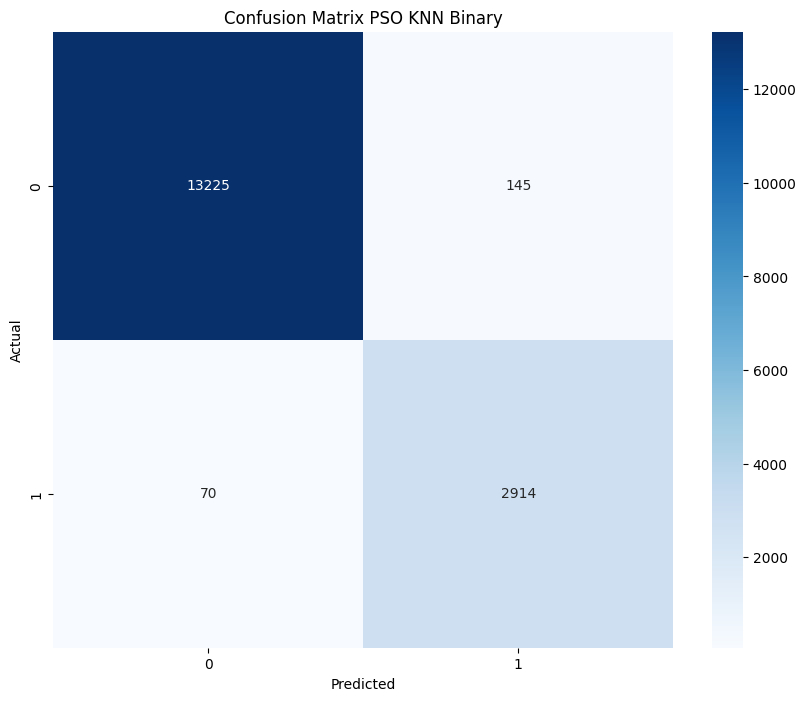

In [34]:
model, pred = train_and_evaluate(model, X, y, Xt, yt)


In [35]:
import joblib
joblib.dump(model,"pso_KNN_alc_binary.pkl")

['pso_KNN_alc_binary.pkl']